# Experimental Notebook

In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_41622/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Ramsey Measurement Induced Dephasing-based RR Kappa (T1) Charecterisation

This consists of:
1. Optional - $\pi$ pulse to prepare qubit in G/E
2. Play Constant Amplitude Measurement Tone for duration $\tau_1$
3. Wait variable delay $\tau_{\kappa}$
4. Play a standard Ramsey Sequence ($\frac{\pi}{2}$ pulse, followed by variable $\tau_R$ delay, followed by another $\frac{\pi}{2}$ pulse)
5. Wait an additional $\tau_B$ to ensure initial RR photons have decayed
6. Measure Qubit

In [17]:
from utils import get_dt_from, convert_arr_to_dt, acquisition_checker

meas_tau_1_dt = 2 * measure_pulse.duration
low_meas_tau_R = 20.0 * ns
high_meas_tau_R = 4 * us
num_tau_R = 116
tau_R_linspace = np.linspace(low_meas_tau_R, high_meas_tau_R, num_tau_R)

buffer_time_dt = measure_delay.duration

meas_duration_dt = 2 * measure_pulse.duration
meas_amps = np.linspace(0.1, 0.5, 5)

delta_freq = 5.0 * MHz

tau_R_linspace/ns

array([  20.        ,   54.60869565,   89.2173913 ,  123.82608696,
        158.43478261,  193.04347826,  227.65217391,  262.26086957,
        296.86956522,  331.47826087,  366.08695652,  400.69565217,
        435.30434783,  469.91304348,  504.52173913,  539.13043478,
        573.73913043,  608.34782609,  642.95652174,  677.56521739,
        712.17391304,  746.7826087 ,  781.39130435,  816.        ,
        850.60869565,  885.2173913 ,  919.82608696,  954.43478261,
        989.04347826, 1023.65217391, 1058.26086957, 1092.86956522,
       1127.47826087, 1162.08695652, 1196.69565217, 1231.30434783,
       1265.91304348, 1300.52173913, 1335.13043478, 1369.73913043,
       1404.34782609, 1438.95652174, 1473.56521739, 1508.17391304,
       1542.7826087 , 1577.39130435, 1612.        , 1646.60869565,
       1681.2173913 , 1715.82608696, 1750.43478261, 1785.04347826,
       1819.65217391, 1854.26086957, 1888.86956522, 1923.47826087,
       1958.08695652, 1992.69565217, 2027.30434783, 2061.91304

580


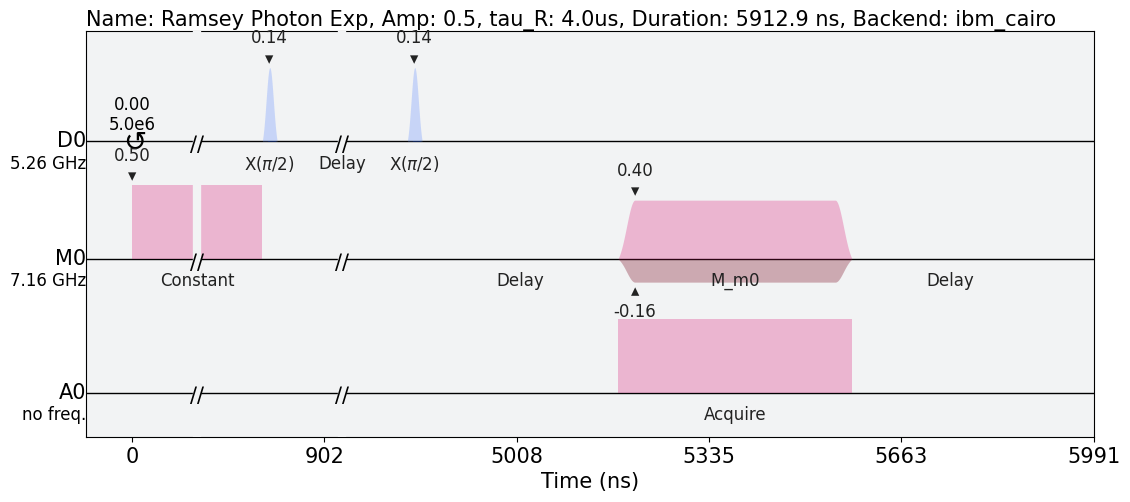

In [18]:
ramsey_exp = []

for amp in meas_amps:
    M1_pulse = pulse.Constant(duration=meas_duration_dt, amp=amp)

    for tau_R in tau_R_linspace:
        tau_R_dt = get_dt_from(tau_R)
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Ramsey Photon Exp, Amp: {int(1e3*amp)/1e3}, tau_R: {int(1e3*tau_R_dt * dt/us)/1e3}us'
        ) as ramsey_meas_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(frequency=delta_freq, channel=qubit_chan)
            pulse.play(M1_pulse, meas_chan)
            pulse.play(sx_pulse, qubit_chan)
            pulse.delay(tau_R_dt, qubit_chan)
            pulse.play(sx_pulse, qubit_chan)
            pulse.delay(buffer_time_dt, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        ramsey_exp.append(ramsey_meas_sched)

print(len(ramsey_exp))

ramsey_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

290


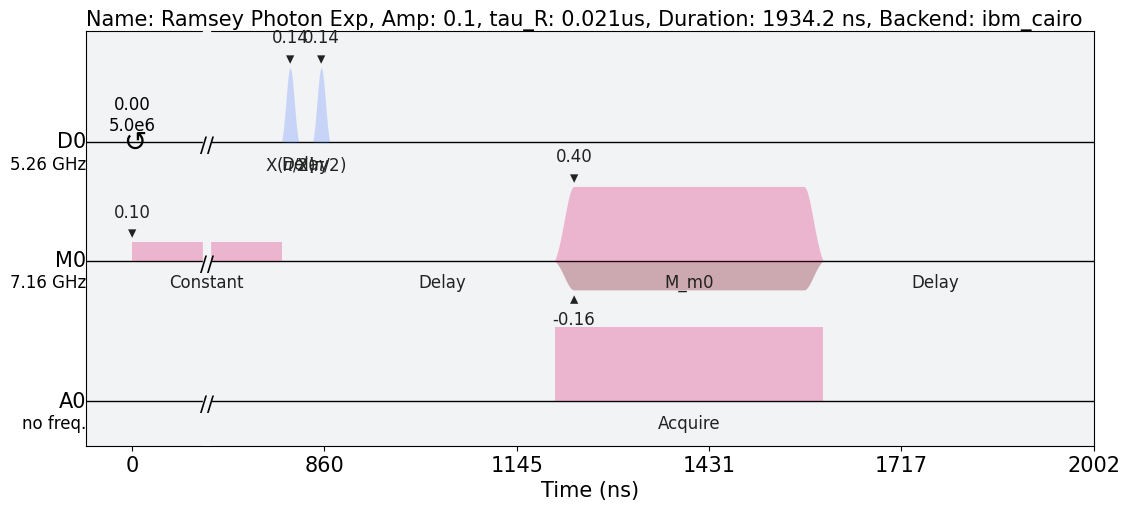

In [20]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

job_1, job_2 = np.array(ramsey_exp).reshape(2, -1).tolist()

print(len(job_1))

job_1[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [22]:
# Running job_1, job_2

job_experiment = backend.run(job_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [ ]:
job_1 = provider.backend.retrieve_job('cpngg7gd7p3000862q20')
job_2 = provider.backend.retrieve_job('cpnggb9dmm10008p26f0')